# Aperture photometry in astronomical images
This Notebook reads a processed astronomical image (preferably with astrometric solution), identifies point-like objects above a given noise level and perform aperture photometry based pre-defined parameters. Tests were made with SAMI and Goodman HTS images.

The pipeline is based on [this Notebook](https://notebook.community/Python4AstronomersAndParticlePhysicists/PythonWorkshop-ICE/notebooks/10_03_Astronomy_PhotUtils)

**Author:** Felipe Navarete

**Date:** Jan 9th, 2023

Parameters:
- **filename** (*str*): the full path of the input ".fits" file
- **sat_lvl** (*float*): the saturation limit of the image (default=*None*)
- **stars_fwhm** (*float*):  the expected FWHM of the stars in arcseconds (default=*1.5*)
- **psf_thresh** (*float*):  the detection threshold (in sigma units) to identify bright stars in the field and compute the median FWHM. If no value is provided, estimate the threshold from image statistics (default=*None*)
- **psf_radius** (*integer*): the radius for estimating the FWHM of the point sources. If no value is provided, assumes 3*FWHM of the bright stars (default=*None*)
- **phot_thresh** (*float*): the detection threshold (in sigma units) to identify the stars in the field and run the photometry (default=*5.0*)
- **pixelscale** (*float*):  the pixel scale of the image in arcsec/pixel. If no value is provided, estimate from fits header (default=*None*)
- **print_psf** (*bool*):    if True, print out all the results of the FWHM estimate on screen instead of only the first one star (default=*False*)
- **bkg_box** (*integer*):       size of box (in pixels) to estimate a low-resolution background grid (default=*34*)
- **filter_size** (*integer*):   set the order of the filter to filter out stars from the background (default=*3*)
- **gain** (*float*):        gain of the observatins (TBD in e/adu or exposure time in seconds, default=*1*).
- **zp** (*float*):          set the photometric zero point to correct the instrumental magnitudes (default=*25.*, assuming exptime = 1 sec).
- **display_tables** (*bool*): Print out photometric tables on screen (default=*False*)

Returns:
- filename + '_aper_phot.csv': photometric table in CSV format with positions and instrumental magnitudes of the detected sources.


Execution:

`auto_phot(filename, sat_lvl=None, stars_fwhm= 1.5, psf_thresh=None, pixelscale=None, psf_radius=None, 
           print_psf=False, phot_thresh= 5.0, bkg_box=34, filter_size=3, gain=1., zp=25., display_tables=False)`

To do:
- supress warnings to clean the on-screen outputs

-----

## 1. Load dependencies and functions
The bulk of the pipeline is based on Astropy and Photutils routines. Numpy, pandas and matplotlib are also required.

In [9]:
%matplotlib inline
from astropy               import units as u
from astropy               import wcs
from astropy.io            import fits
from astropy.coordinates   import SkyCoord
from astropy.modeling      import models, fitting
from astropy.stats         import sigma_clipped_stats, SigmaClip
from astropy.visualization import ZScaleInterval
from datetime              import datetime 
from photutils             import DAOStarFinder, CircularAperture, aperture_photometry, CircularAnnulus
from photutils.background  import Background2D, MedianBackground
from photutils.utils       import calc_total_error
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
####################################
# set default matplotlib parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 13
####################################
# define functions
def display(img, cb_title=''):
    """
      simple function for image visualization
      
      Parameters:
         img (numpy.ndarray): input image
         cb_title (str): label for the color bar (default='')
      
    """
    norm = ZScaleInterval()
    vmin, vmax = norm.get_limits(img)
    plt.imshow(img, vmin=vmin, vmax=vmax, interpolation='none', origin='lower')
    plt.colorbar(label=cb_title)

def get_bkg(img, sigma=3.0, maxiters=5):
    """ 
        Estimate background  statistics (median and standard deviation) 
        of a fits image after applying a sigma-clipping routine
        
        Parameters:
           img (numpy.ndarray): input image
           sigma (float, optional):  number of standard deviations to use for both the lower and upper clipping limit (default=3.0)
           maxiters (int, optional): maximum number of sigma-clipping iterations to perform (default=5)
           
        Returns:
           median, std (float): the median, and standard deviation of the sigma-clipped data
    """
    mean, median, std = sigma_clipped_stats(img, sigma=sigma, maxiters=maxiters)    
    return median, std

def find_stars(img, fwhm=15., sigma_thresh=5.0):
    """
        Uses DAOPhot implementations to detect sorces with a given FWHM and above a detection limit.
        
        Parameters:
           img (numpy.ndarray): input image
           fwhm (float, optional): expected FWHM for the sources (in pixels, default=15)
           sigma_thresh (float, optional): detection limit (in sigmas, default=5.0)
           
        Returns:
           table_detections (astropy.table.table.QTable): table of results containing the following columns:
               ['id', 'xcentroid', 'ycentroid', 'sharpness', 'roundness1', 'roundness2', 'npix', 'sky', 'peak', 'flux', 'mag']
        
    """
    
    bkg, std_bkg = get_bkg(img)
    
    daofind = DAOStarFinder(fwhm=fwhm, threshold=sigma_thresh * std_bkg)
    
    table_detections = daofind(img - bkg)    

    print("  A total of {} sources were detected above a {:.1f}-sigma threshold".format(len(table_detections),sigma_thresh))
    print("")
    
    return table_detections


def displ_table(table, format_cols='%.8g', max_rows=-1, max_cols=-1):
    """
        Set basic definitions to print an Astropy Table on screen
        
        Parameters:
           table (astropy.table.table.QTable): table to print
           format_cols (str, optional): set formating for all tables for consistent output (default='%.8g')
           max_rows (int, optional): maximum number of rows to print (default=-1, all)
           max_cols (int, optional): maximum number of columns to print (default=-1, all)
           
        Returns:
           print the table on screen, no variables to return.
        
    """
    for cols in table.colnames: table[cols].info.format = format_cols  # for consistent table output
    # print entire table
    print(table.pprint(max_lines=max_rows, max_width=max_cols))

def check_saturation(img, sat_lvl=None):
    """
        Check if there are saturated pixels within an image, assuming the saturation level is known.
        
        Parameters:
           img (numpy.ndarray): input image
           sat_lvl (float): saturation limit (default=None)
           
        Returns:
        sat_flag (bool): True if saturated pixels are found.
        
    """
    if sat_lvl is None:
        return False
    else:
        sat_flag=True if np.max(img) >= sat_lvl else False
        return sat_flag
    
def get_fwhm(img, table_sources, source_id=0, pixscale=0.15, stamp_radius=50, sat_lvl=None, psf_model='moffat', fwhm_best_guess = 1.5,
             plot_star=False, plot_psf=False):
    """
        Fit the FWHM of a point like source using a Gaussian or Moffat profile
        
        Parameters:
           img (numpy.ndarray): input image
           table_sources (astropy.table.table.QTable): table of sources from find_stars()
           source_id (in, optional): id of the source to analyse (default=5)
           pixscale (float): the pixel scale of the image (in arcseconds, default=0.15)
           stamp_radius (int, optional): size of the grid to analyze the star (default=50)
           sat_lvl (float, optional): set the saturation level of the image; if a star has saturated pixels, skip the fit (in counts, default=None)
           psf_model (str, optional): 'moffat' or 'gaussian' model (default='moffat')
           fwhm_best_guess (float, optional): if using a 'gaussian' profile. provide the best guess for the FWHM (in arcseconds)
           plot_star (bool, optional): print out the input star on screen (default=False)
           plot_psf (bool, optional): print out the fitting results on screen (default=False)
           
        Returns:
           fwhm (astropy.units.quantity.Quantity): the FWHM of the point source (in arcseconds)
        
    """
    # select a bright (not saturated) source for PSF modelling:
    isource = table_sources[source_id]

    x_cen = int(isource['xcentroid'])
    y_cen = int(isource['ycentroid'])

    if plot_star:
        print ("x pos: " + str(x_cen))
        print ("y pos: " + str(y_cen))
        display(img_star)
        plt.show()

    # if star is saturated, skip fitting
    if sat_lvl is not None:
        img_star = img[int(isource['ycentroid'] - stamp_radius):int(isource['ycentroid'] + stamp_radius), 
                       int(isource['xcentroid'] - stamp_radius):int(isource['xcentroid'] + stamp_radius)]
        if check_saturation(img_star, sat_lvl):
            print("  (Warning) Skipping saturated star...")
            return float("nan")
    
    # get background information
    median, std_bkg = get_bkg(img)

    # Median bkg subtracted image
    img_nobkg = img - median

    # turn the 2D profile into a 1D distance array from the center of each pixel to the centroid of the source estimated by DAOPhot:
    flux_counts = []
    pixel_distance = []

    # Pixels around detection loop
    analysis_radius = int(np.round(stamp_radius))
    for x in range(x_cen - analysis_radius, x_cen + analysis_radius):
        for y in range(y_cen - analysis_radius, y_cen + analysis_radius):
            flux_counts.append(((img_nobkg[y][x]) / isource['peak']))
            pixel_distance.append(np.linalg.norm((isource['xcentroid'] - x, isource['ycentroid'] - y)))

    if psf_model == 'gaussian':
        # Fit the data using a Gaussian profile (amplitude, mean, stddev)
        model_init = models.Gaussian1D(amplitude=1.0, mean=0, stddev=fwhm_best_guess)
    elif psf_model == 'moffat':
        # Fit the data using a Moffat model (amplitude, x_0, gamma, alpha)
        model_init = models.Moffat1D(amplitude=1.0, x_0=0, gamma=2., alpha=3.5)
    else:
        raise Exception("Unknown model type: %s. Must be gaussian or moffat." % psf_model)

    # fit the 1D profile
    fitter     = fitting.SimplexLSQFitter()
    fitted_psf = fitter(model_init, pixel_distance, flux_counts, maxiter=50)

    # if amplitude is <= 0, abort
    if fitted_psf.amplitude <= 0:
        print("  (Warning) Bad fitting: Amplitude is negative. Aborting.")
        print("")
        return float("nan")
    
    # FHWM conversion
    if psf_model == 'gaussian':
        fwhm_fit = 2.355 * fitted_psf.stddev * pixscale
    elif psf_model == 'moffat':
        fwhm_fit = fitted_psf.gamma * 2 * np.sqrt(2 ** (1. / fitted_psf.alpha) - 1) * pixscale
    else:
        raise Exception("Unknown model type: %s. Must be gaussian or moffat." % psf_model)
        
    if plot_psf:
        print("")
        print("PSF fitting results - model: {}".format(psf_model))
        print("  Fit value: {:.8g}".format(fitter.fit_info['final_func_val']))
        print("  PSF FWHM: {:.8g}".format(fwhm_fit))
        print("       SNR: {:.8g}".format(np.sqrt(isource['flux'])))
        print("")

        # Check fitting
        color = 'green' if fitter.fit_info['final_func_val'] < 5.0 else 'red'

        plt.figure()
        plt.plot(pixel_distance, flux_counts, 'ko')
        rx = np.linspace(0, int(max(pixel_distance)), int(max(pixel_distance)) * 10)
        plt.plot(rx,
                 fitted_psf(rx),
                 color=color,
                 lw=3.0,
                 label='SNR: %.2f, Fit: %.2f, FWHM: %.2f"' % (np.sqrt(isource['flux']),
                                                              fitter.fit_info['final_func_val'],
                                                              fwhm_fit))
        plt.xlabel('Distance (pixels)')
        plt.ylabel('Normalized flux (ADU)')
        plt.title('%s profile fit' % psf_model)
        plt.legend()
        plt.show()
    
    return fwhm_fit

def get_bkg2d(img, bkg_box=34, filter_size=3, plot_results=False):
    """
        Estimate a 2d background using an input fits image
        
        Parameters:
           img (numpy.ndarray): input image - provide full path and 
           bkg_box (int, optional): The box size along each axis (default=34)
           filter_size (int, optional): The window size of the 2D median filter to apply to the low-resolution background map. (default=3)
           plot_results (bool, optional): print out the results on screen
           
        Returns:
           fwhm (astropy.units.quantity.Quantity): the FWHM of the point source (in arcseconds)
        
    """

    sigma_clip = SigmaClip(sigma=3., maxiters=10)
    bkg_estimator = MedianBackground()
    bkg = Background2D(img, (bkg_box, bkg_box), filter_size=(filter_size, filter_size),
                       sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    if plot_results:
        display(bkg.background)
        plt.show()

    return bkg.background

def do_phot(img, positions, bkg=None, gain=1., r_in=10, r_out=None):
    """
        Perform aperture photometry on an input fits image
        
        Parameters:
           img (numpy.ndarray): input image
           positions (numpy.array): array of (x,y) values for extracting the photometry 
           bkg (numpy.ndarray, optional): input background estimate (default=None)
           gain (float, optional): ratio of counts to the units of img to calculate the Poisson error of the sources.
                                   If gain is zero, then the source Poisson noise component will not be included (default=1.)
           r_in (float, optional): radius of the circle to measure the flux. (in pixels, default=10)
           r_out (float, optional): the outer radius of the circular annulus (in pixels, default=None)
           
        Returns:
           table_phot (astropy.table.table.QTable): table of results containing the following columns:
               ['id', 'xcenter', 'ycenter', 'aperture_sum', 'aperture_error', 'annulus_sum', 'annulus_error',
                'aperture_sum_nobkg', 'aperture_sum_nobkg_error', 'SNR']
    """
    
    if bkg is not None:
        img_nobkg = img - bkg
        # remove nan values from background
        bkg[np.isnan(bkg)]=0.0
        # assumes the error is Poisson (so all pixels must be positive!)
        bkg_error = np.sqrt(abs(bkg))
        phot_error = calc_total_error(img, bkg_error, gain)
        
        img = img_nobkg
    
    # if no r_out is provided, perform simple aperture photometry
    aper_in = CircularAperture(positions, r=r_in)
    if r_out is not None: annulus_apertures = CircularAnnulus(positions, r_in=r_in, r_out=r_out)
    
    apertures = aper_in
    if r_out is not None: apertures = [aper_in,annulus_apertures]
    
    if bkg is None:
        table_phot = aperture_photometry(img, apertures)
    else:
        table_phot = aperture_photometry(img, apertures, error=phot_error)
    
    # remove background using the annulus
    if r_out is not None: 
        table_phot.rename_column('aperture_sum_0', 'aperture_sum')
        table_phot.rename_column('aperture_sum_1', 'annulus_sum')
        table_phot.rename_column('aperture_sum_err_0', 'aperture_error')
        table_phot.rename_column('aperture_sum_err_1', 'annulus_error')

        # Use the aperture_sum_1 to estimate the level of background around the source. We need to know the area of the annulus for this estimation:
        bkg_mean = table_phot['annulus_sum'] / annulus_apertures.area
        # Now remove the background estimation to all pixels in the aperture:
        bkg_aper = bkg_mean * aper_in.area
        flux_nobkg = table_phot['aperture_sum'] - bkg_aper
        
        
        err_ap = table_phot['aperture_error']  / aper_in.area
        err_an = table_phot['annulus_error']  / annulus_apertures.area
        err_nobkg = np.sqrt(err_ap**2+err_an**2)*aper_in.area
        
        table_phot['aperture_sum_nobkg'] = flux_nobkg
        table_phot['aperture_sum_nobkg_error'] = err_nobkg
        #table_phot['aperture_sum_nobkg_error'] = table_phot['aperture_error']
        table_phot['SNR'] = table_phot['aperture_sum_nobkg'] / table_phot['aperture_sum_nobkg_error']
    else:
        table_phot.rename_column('aperture_sum_err', 'aperture_error')
        
        table_phot['SNR'] = table_phot['aperture_sum'] / table_phot['aperture_error']
        
    # now plot a section of the image to display the targets
    display(img[0:800, 0:800])
    if r_out is not None: annulus_apertures.plot(color='purple', lw=2, alpha=1)
    aper_in.plot(lw=2, ls=':', color='white')
    plt.show()
    
    return table_phot

def table_xy2sky(table, img_wcs, exptime=1., zp=25.):
    """
        Read photometric table from do_phot() and converts (x,y) position and flux values to sky (RA,Dec) and magnitudes
        
        Parameters:
           table (astropy.table.table.QTable): table from do_phot()
           img_wcs (astropy.wcs.wcs.WCS): input WCS from the fits file
           exptime (float, optional): exposure time of the observations in seconds (default=1.)
           zp (float, optional): the photometric zero-point offset to be added to the instrumental magnitudes (default=25.)
           
        Returns:
           table_out (astropy.table.table.QTable): table of results containing the following columns:
               ['id', 'ra', 'dec', 'm', 'e_m', 'SNR']
        
    """
    
    # prepare the output list
    # convert (x,y) to (RA,Dec)
    coords_xy = np.array([table['xcenter'], table['ycenter']]).T
    coords_wcs = img_wcs.all_pix2world(coords_xy,0)
    
    # 
    
    table_out = table.copy()
    
    # check if WCS is present
    if img_wcs.wcs.ctype[0] == '':
        table_out['x'], table_out['y'] = coords_wcs[:,0], coords_wcs[:,1]
    else:
        table_out['ra'], table_out['dec'] = coords_wcs[:,0], coords_wcs[:,1]
    
    # if errors are provided, run:
    if 'aperture_sum_nobkg_error' in table_out.colnames: 
        table_out['m'] = zp -2.5 * np.log10(table['aperture_sum_nobkg']/exptime)
        table_out['e_m'] = np.sqrt( ( ( 2.5 / np.log(10) ) * table['aperture_sum_nobkg_error'] / table['aperture_sum_nobkg'] )**2 )
        table_out.remove_columns(['xcenter','ycenter','aperture_sum','aperture_error','annulus_sum','annulus_error','aperture_sum_nobkg','aperture_sum_nobkg_error'])

    else:
        table_out['m'] = zp -2.5 * np.log10(table['aperture_sum']/exptime)
        table_out['e_m'] = np.sqrt( ( ( 2.5 / np.log(10) ) * table['aperture_error'] / table['aperture_sum'] )**2 )
        table_out.remove_columns(['xcenter','ycenter','aperture_sum','aperture_error'])

    # check if WCS is present
    if img_wcs.wcs.ctype[0] == '':
        table_out = table_out['id','x','y','m','e_m','SNR']
    else:
        table_out = table_out['id','ra','dec','m','e_m','SNR']
        
    return table_out

###############################################################
def auto_phot(filename, sat_lvl=None,
              stars_fwhm= 1.5,
              psf_thresh=None, pixelscale=None, psf_radius=None,  print_psf=False,
              phot_thresh= 5.0, 
              bkg_box=34, filter_size=3,
              gain=1., zp=25.,
              display_tables=False):
    
    """
       A wrapper to execute all procedures as a pipeline

         Open a fits image, get WCS information from header.
         Detect bright stars and evaluate the median FWHM of non-saturated objects.
         Run aperture photometry using an aperture and annulus radii based on the FWHM estimated from the bright stars
         Saves output as a CSV file.
       
       Parameters:
         filename (str):                the full path of the input ".fits" file
         sat_lvl (float, optional):     the saturation limit of the image (default=None)
         stars_fwhm (float, optional):  the expected FWHM of the stars (in arcseconds, default=1.5)
         psf_thresh (float, optional):  the detection threshold (in sigma units) to identify bright stars
                                         in the field and compute the median FWHM. If no value is provided,
                                         estimate the threshold from image statistics (default=None)
         psf_radius (int, optional):    the radius for estimating the FWHM of the point sources. If no value
                                         is provided, assumes 3*FWHM of the bright stars (default=None)
         phot_thresh (float, optional): the detection threshold (in sigma units) to identify the stars
                                         in the field and run the photometry (default=5.0)
         pixelscale (float, optional):  the pixel scale of the image in arcsec/pixel. If no value is provided,
                                         estimate from fits header (default=None)
         print_psf (bool, optional):    if True, print out all the results of the FWHM estimate on screen
                                         instead of only the first one star (default=False)
         bkg_box (int, optional):       size of box (in pixels) to estimate a low-resolution background grid (default=34)
         filter_size (int, optional):   set the order of the filter to filter out stars from the background (default=3)
         gain (float, optional):        gain of the observatins (TBD in e/adu or exposure time in seconds, default=1).
         zp (float, optional):          set the photometric zero point to correct the instrumental magnitudes (default=25., assuming exptime = 1 sec).
         display_tables (bool, optional): Print out photometric tables on screen (default=False)

        Returns:
          phot_df (pandas dataframe): photometric table with positions and instrumental magnitudes of the detected sources.
          CSV file:                   photometric table in CSV format with positions and instrumental magnitudes of the detected sources.
          
    """
    
    # to compute execution time
    start_time = datetime.now() 
    
    # remove '.fits' if existing
    filename = filename.rsplit('.fits', 1)[0]
    print('Running aperture photometry on image {}'.format(filename.rsplit('/', 1)[1]))
    
    # open the fits file
    with fits.open(filename+'.fits') as hdu:
        hdr = hdu[0].header
        img = hdu[0].data
        img_wcs = wcs.WCS(hdr)
    
    
    # replace Nan by zeros, if any
    img[np.isnan(img)] = 0
    
    
    # get image parameters
    bkg, std_bkg = get_bkg(img)
    img_stat=np.percentile(img,[0.,1.,50.,99.,100.])
    
    print("")
    print("Image statistics:")
    print("  Background level (ADU): {:.4f}".format(bkg))
    print("  Background noise (ADU): {:.4f}".format(std_bkg))
    print("  Image median  (ADU): {:.4f}".format(img_stat[2]))
    print("  Image  1% cut (ADU): {:.4f}".format(img_stat[1]))
    print("  Image 99% cut (ADU): {:.4f}".format(img_stat[3]))
    print("  Image minimum (ADU): {:.4f}".format(img_stat[0]))
    print("  Image maximum (ADU): {:.4f}".format(img_stat[4]))
    print("  Image max   (sigma): {:.4f}".format(img_stat[4]/std_bkg))
    print("  Image 99%   (sigma): {:.4f}".format(img_stat[3]/std_bkg))
    print("")
    
    # get pixel scale in (arcsec/pixel) units
    if pixelscale is None:
        pixscale = wcs.utils.proj_plane_pixel_scales(img_wcs)[0] # here I'm assuming squared pixels, so pixscale[0]=pixscale[1]
        if pixscale == 1:
            print("  (Warning) WCS might not be present in the data. Using (x,y) coordinates")
            if hdr['INSTRUME'] == 'Goodman Spectro':
                print("  Goodman data found. Setting pixel scale based on the binning information from the header.")
                binning = np.array([int(b) for b in hdr['CCDSUM'].split(' ')])[0]
                pixscale = binning * 0.15 # Goodman pixscale is binning * 0.15 arcsec/pixel
        else:
            pixscale *= 3600.
    else:
        pixscale = pixelscale

    # convert from arcsec to pixels using the pixelscale of the instrument
    fwhm_pixel = ( stars_fwhm / pixscale )
    
    if psf_thresh is None:
        # automatic select the detection threshold for estimate the PSF
        psf_thresh = round(img_stat[3]/std_bkg)
        
    # run DAOFind to detect bright stars to estimate the FWHM
    print("")
    print('Finding bright stars above {}-sigma to estimate the FWHM...'.format(psf_thresh))
    sources_psf = find_stars(img, fwhm=fwhm_pixel, sigma_thresh=psf_thresh)

    # show image with detections
    display(img)
    plt.scatter(sources_psf['xcentroid'], sources_psf['ycentroid'], s=200, alpha=0.5, facecolors='none', edgecolors='black')
    # display id's
    txt_id = sources_psf['id']-1
    x = sources_psf['xcentroid']
    y = sources_psf['ycentroid']
    for i, txt in enumerate(txt_id):
        plt.annotate(txt, (x[i], y[i]))
    plt.show()
    
    # use bright and non-saturated stars to estimate the median FWHM of the PSF
    psf_radius = round(3. * fwhm_pixel)
    
    list_fwhm =[]
    if len(sources_psf['id']) > 25:
        print("  (warning) Too many bright stars found. Using only the top-25 ones.")
        print("")
    for idx, psf_id in enumerate(sources_psf['id']-1):
        # in case of too many stars found, use only the first 25 ones:
        if idx < 25:
            plot_psf = True if idx == 0 else False
            # get the FWHM of the PSF
            fwhm_psf0 = get_fwhm(img, sources_psf, pixscale=pixscale, source_id=psf_id, stamp_radius=psf_radius, psf_model='moffat', sat_lvl=sat_lvl,
                                plot_star=False, plot_psf=plot_psf)
            list_fwhm.append(fwhm_psf0)
    # transform the list into an array and get statistics
    list_fwhm = np.array(list_fwhm)
    list_fwhm = list_fwhm[~np.isnan(list_fwhm)]
    
    # median FWHM
    fwhm_psf  = np.median(list_fwhm)
    #median absolute error (MAD)
    efwhm_psf = np.median(np.absolute(list_fwhm - np.median(list_fwhm)))
    
    print("")
    print("PSF statistics based on {} stars:".format(len(list_fwhm)))
    print("  Median FWHM (arcsec): {:.3f}".format(fwhm_psf))
    print("   Error FWHM (arcsec): {:.3f}".format(efwhm_psf))
    print("")
    
    # background modelling
    ##############################
    bkg2d = get_bkg2d(img, bkg_box=bkg_box, filter_size=filter_size, plot_results=True)
    
    # aperture photometry
    # set the aperture radius as equivalent to the FWTM of a Gaussian with FWHM given by 'fwhm'
    #############################
    fwtm2fwhm = 4.29193/2.35482 # ratio between the full width at tenth maximum and FWHM
    aperture_radius = ( fwhm_psf * fwtm2fwhm / pixscale ) # in pixels
    
    print("")
    print("Performing aperture photometry using aperture and annulus radii defined below:")
    print('  Aperture radius (arcsec): {:5.2f}'.format(   aperture_radius * pixscale))
    print('   Anullus radius (arcsec): {:5.2f}'.format(1.5*aperture_radius * pixscale))

    # run DAOFind to detect all  stars above the given threshold
    sources = find_stars(img, fwhm=fwhm_pixel, sigma_thresh=phot_thresh)

    # show image with detections
    display(img)
    plt.scatter(sources['xcentroid'], sources['ycentroid'], s=200, alpha=0.5, facecolors='none', edgecolors='black')
    plt.show()
    
    if display_tables:
        displ_table(sources, max_rows=10)
    
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

    table_phot = do_phot(img, positions, bkg=bkg2d, gain=1., r_in=aperture_radius, r_out=1.5*aperture_radius)
    
    if display_tables:
        displ_table(table_phot, max_rows=20)
    
    # converts from image to sky coordinates and magnitudes
    #############################
    try:
        table_out = table_xy2sky(table_phot, img_wcs, exptime=hdr['EXPTIME'], zp=zp)
    except:
        print("  No WCS found. Output will return (x,y) positions and instrumental magnitudes.")
        table_out = table_phot
        
    displ_table(table_out,max_rows=10)

    df = table_out.to_pandas()
    df.to_csv(filename+'_aper_phot.csv', index=False)
    
    time_elapsed = datetime.now() - start_time
    print('--------------------------------------------------')
    print('  Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))
    print('--------------------------------------------------')
    
    return df

print('Packages loaded.')

Packages loaded.


Running aperture photometry on image 0449_VFTS682_g



Image statistics:
  Background level (ADU): 718.0000
  Background noise (ADU): 128.4016
  Image median  (ADU): 721.0000
  Image  1% cut (ADU): 502.0000
  Image 99% cut (ADU): 1615.0000
  Image minimum (ADU): 495.0000
  Image maximum (ADU): 56289.0000
  Image max   (sigma): 438.3823
  Image 99%   (sigma): 12.5777

  (Warning) WCS might not be present in the data. Using (x,y) coordinates
  Goodman data found. Setting pixel scale based on the binning information from the header.

Finding bright stars above 13-sigma to estimate the FWHM...
  A total of 234 sources were detected above a 13.0-sigma threshold



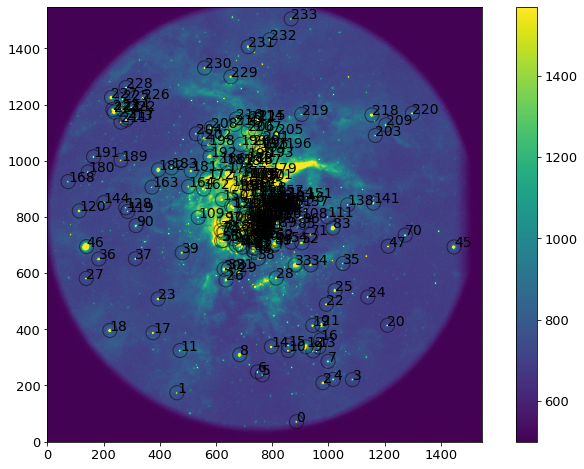

  (warning) Too many bright stars found. Using only the top-25 ones.


PSF fitting results - model: moffat
  Fit value: 1.7373764
  PSF FWHM: 1.2379548
       SNR: 1.0420159



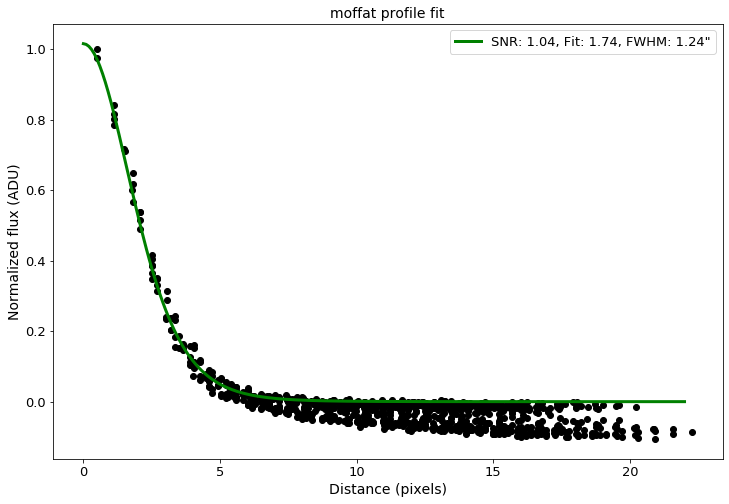


PSF statistics based on 25 stars:
  Median FWHM (arcsec): 1.136
   Error FWHM (arcsec): 0.032



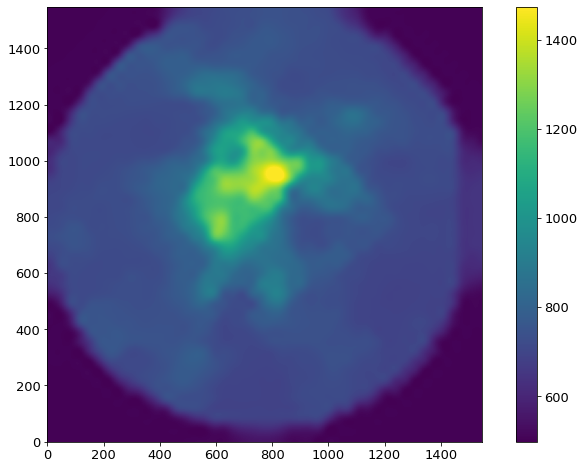


Performing aperture photometry using aperture and annulus radii defined below:
  Aperture radius (arcsec):  2.07
   Anullus radius (arcsec):  3.11
  A total of 1293 sources were detected above a 1.0-sigma threshold



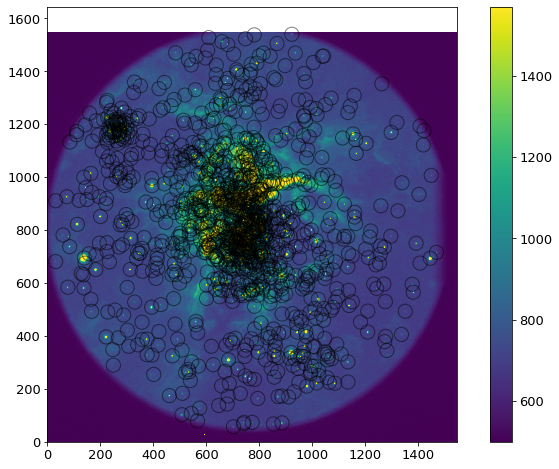

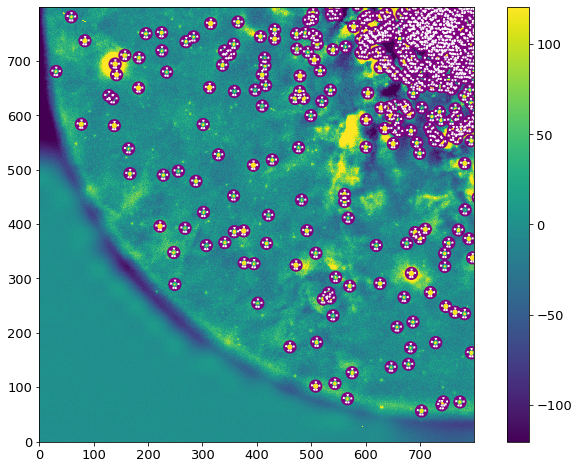

 id      x         y         m         e_m        SNR   
---- --------- --------- --------- ----------- ---------
   1 704.06087 57.237932 16.920428 0.075655878 14.350983
   2 741.52467 68.640573 16.943314 0.080094598 13.555673
   3 854.91966 68.052784 16.919277 0.076868357 14.124618
 ...       ...       ...       ...         ...       ...
1291 610.67588 1528.2946 18.090177  0.23301628 4.6594864
1292 782.73046 1538.6079 18.450011  0.32775219 3.3126742
1293 924.56753 1540.7992 16.824992 0.070395335 15.423411
Length = 1293 rows
None
--------------------------------------------------
  Time elapsed (hh:mm:ss.ms) 0:00:13.433759
--------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:369: RuntimeWarning: invalid value encountered in log10


,id,x,y,m,e_m,SNR
0,1,704.060871,57.237932,16.920428,0.075656,14.350983
1,2,741.524666,68.640573,16.943314,0.080095,13.555673
2,3,854.919657,68.052784,16.919277,0.076868,14.124618
3,4,887.504814,71.996864,15.419516,0.020137,53.917184
4,5,743.985379,73.900700,16.545397,0.055880,19.429802
...,...,...,...,...,...,...
1288,1289,660.405676,1512.800174,15.552465,0.023725,45.763465
1289,1290,749.473850,1523.812741,16.954993,0.083619,12.984269
1290,1291,610.675882,1528.294587,18.090177,0.233016,4.659486
1291,1292,782.730462,1538.607865,18.450011,0.327752,3.312674


In [10]:
###################################################################################
stars_fwhm= 1.5 # the expected FWHM of the stars in the image
phot_thresh= 4.0
pixelscale = None
zp=25.
display_tables=False
sat_lvl = 50000
###################################################################################

filename = 'D:/SOAR/SAM/SO2022B-014/results/NGC121_D_2022-10-17/NGC121_D_B.fits'
#psf_thresh  = 5
#phot_thresh = 3.0

filename        = 'D:/SOAR/Goodman/2023-01-05/2023-01-05/0449_VFTS682_g.fits'
phot_thresh = 1.0
#psf_thresh=100
psf_thresh=None

# remove '.fits' if existing
filename = filename.rsplit('.fits', 1)[0]

auto_phot(filename, stars_fwhm=stars_fwhm, psf_thresh=psf_thresh, sat_lvl=sat_lvl, phot_thresh=phot_thresh, pixelscale=pixelscale, display_tables=False)